# Description

**Project name**: Identifying a household's energy fingerprint with KMeans clustering (2020)

**Author** : Seydou DIA

**Last update**: 08-02-2020

**Entire notebook running time**:1min14s <br>with AMD Ryzen 7 3750H - Radeon Vega Mobile Gfx 2.30 GHz

**Contact**:<br>
* [Linkedin](https://www.linkedin.com/in/seydou-dia-325b04139)
* @:seydou.dia@insa-lyon.fr

For more projects on machine learning and energy click here >
[Data Science Portfolio](https://seydoudia.github.io/Data-Science-portfolio/)

The goal of this notebook is to perform a clustering of different consumption profiles of a household based on the data of their electric meter. The objective is to present the method when performing clustering on energy data. This project includes, data processing, data pre-analysis, model building and analysis of the results.

Throughout the notebook, the reader will find various comments along with the code that explain the different steps and the choices made when analysing data or building the model.


**Part I** of the notebook mainly focuses on the processing of the data whereas **Part II** focuses on the analysis of the data and the building of the machine learning model as well as its evaluation.
**I invite any reader interested in Part II to directly go to cell n° 25**
<br><br>
For **references** go to end of notebook

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Imports

In [2]:
# os related
from os import environ as env
from os.path import join

# data related
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

# visual related
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.colors


# ML related
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

## Paths

In [3]:
DIR_ROOT = join(env["CODE_PATH"], "Cluster_Electricity") # project path
DIR_CODE = join(DIR_ROOT, "Code") # code path
DIR_RAW = join(DIR_ROOT, 'Raw') # raw data path


CONS_PATH = join(DIR_RAW, 'household_power_consumption.txt')

Let's load the raw data and see how it looks like

# Pre-processing

In [4]:
df_cons = pd.read_csv(CONS_PATH, sep=';')

C:\Users\goget\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_cons.head(3)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [6]:
df_cons.tail(3)

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
2075256,26/11/2010,21:00:00,0.938,0,239.82,3.8,0,0,0.0
2075257,26/11/2010,21:01:00,0.934,0,239.7,3.8,0,0,0.0
2075258,26/11/2010,21:02:00,0.932,0,239.55,3.8,0,0,0.0


In [7]:
df_cons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


The first look at the dataset shows us that there are 9 different columns and our data is separated by 1 minute intervals between 2006 and 2010. Data from column 2 to 4 represents the measurements taken by the main meter of the households. Sub-metering 1, 2 and 3 respectively represent electricity consumption of the kitchen, laundry room and finally water-heater and air-conditioner. We will be presenting the units of these columns later in this notebook. 


Digging a bit deeper in our dataset, we notice that it will need a bit of processing since the numeric features are considered as objects data types instead of floats(except for sub_metering 3). Although in this project our clustering algorithm will be applied on the active power data, we will process the entire dataset.


Furthermore, a bit of process will be done on the Date and Time column since we will be merging both of them and converting to datetime format.

More info about dataset can be found [HERE](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption  )

In [8]:

index = df_cons["Date"] + ' ' + df_cons['Time'] # Merging
date_index = [dt.datetime.strptime(d, '%d/%m/%Y %H:%M:%S') for d in index] # Converting
                                                                           # to datetime

In [9]:
df_cons.index = date_index # setting datetime as index
df_cons.drop(columns=['Date', 'Time'], inplace=True)

In [10]:
col_names = df_cons.columns
df_cons.columns = [col_name.lower() for col_name in col_names] # This is just to ease
                                                               # the typing when coding 

In [11]:
# Converting object columns to float
cols = df_cons.select_dtypes(exclude=['float']).columns
proc_df = df_cons.copy()
proc_df[cols] = df_cons[cols].apply(pd.to_numeric,errors='coerce')


In [12]:
proc_df.head()

,global_active_power,global_reactive_power,voltage,global_intensity,sub_metering_1,sub_metering_2,sub_metering_3
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


Now that the preprocessing is done, we can analyse the data that we have at our disposal by **checking if there are any missing values.**

In [13]:
proc_df.isnull().sum()

global_active_power      25979
global_reactive_power    25979
voltage                  25979
global_intensity         25979
sub_metering_1           25979
sub_metering_2           25979
sub_metering_3           25979
dtype: int64

We can see that for each column we have the same number of missing values. We can assume that missing values occurr at the same index for each column. Maybe a hole in the data or random indexes where data is missing. Let's dig into it, even if the purcentage of missing values is very low in comparaison to the entire dataset. 

In [14]:
purc_miss = 100*(df_cons.isnull().sum()[-1]/len(df_cons.index))

print(' Missing values only represent', round(purc_miss,2), '% of the entire dataset')

 Missing values only represent 1.25 % of the entire dataset


In response to this problem we could impute all nan values with the mean of each column, ffill, bfill or interpolate missing values. Before making a choice let's find if out if missing data always appears for the same indexes throughout different columns. 

In [15]:

list_cols = proc_df.columns
for i in range(len(proc_df.columns)-1):
    index_i = proc_df[pd.isnull(proc_df[list_cols[i]])].index.tolist() # Retrieving every row with nan for col i
    index_i1 = proc_df[pd.isnull(proc_df[list_cols[i+1]])].index.tolist() # Retrieving every row with nan for col i+1

    if index_i == index_i1:
        print("nan rows are the same in column ", list_cols[i], " and ", list_cols[i+1])

nan rows are the same in column  global_active_power  and  global_reactive_power
nan rows are the same in column  global_reactive_power  and  voltage
nan rows are the same in column  voltage  and  global_intensity
nan rows are the same in column  global_intensity  and  sub_metering_1
nan rows are the same in column  sub_metering_1  and  sub_metering_2
nan rows are the same in column  sub_metering_2  and  sub_metering_3


The piece of code above confirms our first assumption with missing values appearing on the same rows for each column. This is quite reassuring since it will ease the processing of the dataset. 

Let's now find out where are these missing values in the dataset. In order to do so, we will plot the nan occurences.
Since the missing values always occur at the same time for every row, we will only perform the study on one column. In our case the **'GLOBAL ACTIVE POWER'** column

In [16]:
null_active_power = pd.DataFrame(proc_df[pd.isnull(proc_df['global_active_power'])]['global_active_power'])

In [17]:

plot_df = proc_df[['global_active_power']].copy()
plot_df.rename(columns={'global_active_power':'Global Active Power Nan occurences'}, inplace=True)


In [18]:

plot_df['Global Active Power Nan occurences'].loc[plot_df['Global Active Power Nan occurences'].notnull()] = 0
plot_df['Global Active Power Nan occurences'].loc[plot_df['Global Active Power Nan occurences'].isnull()] = 10


<IPython.core.display.Javascript object>


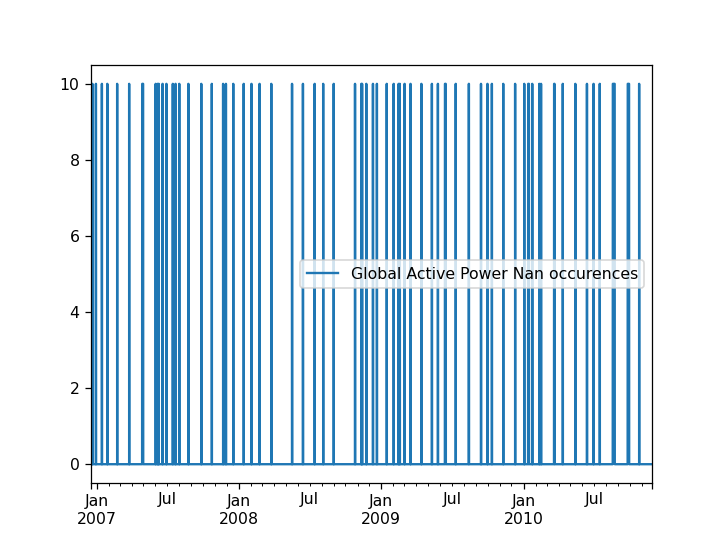

In [19]:
plot_df.plot()

By analysing the plot above in detail (we invite the reader to zoom in a little bit by running the cell) we can notice that missing values occur pretty much randomly arond the dataset. We do not have a big hole in the data which is a good news. Very often it is only data from one minute that is missing. Since it is the case for various parts of our dataset, will interpolate missing values with the linear method.

In [20]:
X_df = proc_df.interpolate(methode='linear')

In [21]:
X_df.isnull().sum()

global_active_power      0
global_reactive_power    0
voltage                  0
global_intensity         0
sub_metering_1           0
sub_metering_2           0
sub_metering_3           0
dtype: int64

Now that our dataset is ready, we will just create a dictionnary with column names as key and units as value

In [22]:
units = dict.fromkeys(df_cons.columns)

In [23]:
units['global_active_power'] = 'kw'
units['global_reactive_power'] = 'kvar'
units['voltage'] = 'volts'
units['global_intensity'] = 'A'
units['sub_metering_1'] = 'kwh'
units['sub_metering_2'] = 'kwh'
units['sub_metering_3'] = 'kwh'


# more info about dataset can be found at
# https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption  

In [24]:
units

{'global_active_power': 'kw',
 'global_reactive_power': 'kvar',
 'voltage': 'volts',
 'global_intensity': 'A',
 'sub_metering_1': 'kwh',
 'sub_metering_2': 'kwh',
 'sub_metering_3': 'kwh'}

Now that our data is ready, we can focus on performing the clustering of consumption profiles. In our case we will only be focusing on the global active power since it represents the data of the main electric meter of our household. On top of that,  The idea of our cluster, is to identify which type of day it is. If it is either a working, an idle day or just a typical day. Before choosing the number of centeroids we will calculate **silhouette scores**.   



Here is how our work will be organized:
* Pre-Analysis of active power data
* Building of the model with Kmeans
* Calculation of Silhouette scores
* Analysis of the results
* Potential futur steps for the project for those who are interested

# Pre-analysis of active power data

In [25]:
df_active = X_df[["global_active_power"]].copy()

In [26]:
df_active.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 1 columns):
 #   Column               Dtype  
---  ------               -----  
 0   global_active_power  float64
dtypes: float64(1)
memory usage: 31.7 MB


Let's convert our active power data to **energy consumption** and come back to an **hourly timestep**. According to the website from where we fethed the data, the units are in Kw. thus, we will have to come back to Kwh and do an hourly resample by summing each cell.

In [27]:

df_active['energy_cons'] = df_active['global_active_power'] * (60/3600)


In [28]:
hourly_df = df_active[['energy_cons']].resample('1H').sum()
units['energy_cons'] = 'kwh'

In [29]:
hourly_df

,energy_cons
2006-12-16 17:00:00,2.533733
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467
...,...
2010-11-26 17:00:00,1.725900
2010-11-26 18:00:00,1.573467
2010-11-26 19:00:00,1.659333
2010-11-26 20:00:00,1.163700


<IPython.core.display.Javascript object>


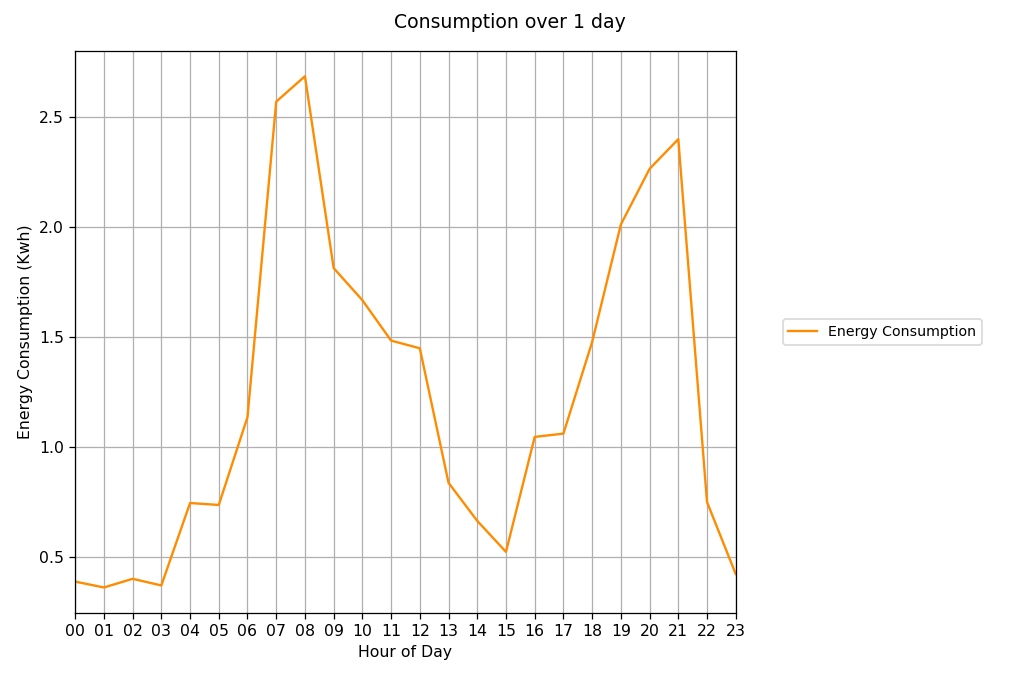

In [30]:
start = "2009-12-01 00:00:00"
end = "2009-12-01 23:00:00"

df = hourly_df[start:end]

# df = df.resample('30s').interpolate(methode='linear')
#df['sold_to_grid'] = df['bought_from_grid']
#df['bought_from_grid'].loc[df['bought_from_grid'].values < 0 ] = np.nan
#df['sold_to_grid'].loc[df['bought_from_grid'].values > 0 ] = np.nan
# ---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 2, sharex=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})

pax, _ = axs
pax.plot(df.index, df["energy_cons"], label="Energy Consumption",
         color="darkorange", linewidth=1.5)

pax.grid(True)
#-----------------
pax.set_xlim([df.index[0], df.index[-1]])
pax.set_xticks(df.index.tolist())
pax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H"))
# pax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b %d"))
pax, lax = axs
pax.set_ylabel("Energy Consumption (Kwh)")
pax.set_xlabel("Hour of Day")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)


# ----------------
fig.suptitle("Consumption over 1 day")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0, 0, 1, 0.95])
# savefig(fig_name='simulated_plot_site_cons', path=DIR_FIG)



Above, we have plotted the energy consumption for each hour on december 1 of the year 2009 which was a Monday. We see that we have two spikes during the morning and the evening throughout the day. The curve seems pretty logical for a business day since in the morning the people living in the house are waking up and consuming electricity to prepare their day. At night we see the same phenomenon since people are back at home. During the day consumption is lower.



From there wa can assume that there are various consumption profiles. For example we could think of:
* A Saturday where the occupants are staying at home and consuming electricity throughout the entire day

* Or a holiday where everyone would have left the house and the consumption is pretty low throughout the entire day

* A day where a party is organized at the house and we notice an important electricity consumption throughout the entire day

* And so on.....


If we had all the time in the world and nothing else to do, we could have analyse data of each day and try to differentiate consumption profiles. But since it is not the case, a clustering algorithm comes in handy...



By defining the number of clusters (which represents the number of groups we want to differenciate) we will be able to identify groups of consumption profiles. But before, we will perform a small transformation to our dataset. We will go from a one column hourly timestep to a 24 columns daily timestep. In this way, based on the consumption of each hour for a given day (and index in our case), we will be able to assign it to one of the clusters our algorithm would have identified.

In [31]:
hourly_df['hour'] = hourly_df.index.hour
hourly_df.index = hourly_df.index.date
pivot_df = hourly_df.pivot(columns='hour')
pivot_df = pivot_df.dropna()


In [32]:
pivot_df.head()


energy_cons                                                    \
hour                0         1         2         3         4         5    
2006-12-17    1.882467  3.349400  1.587267  1.662200  2.215767  1.996733   
2006-12-18    0.276367  0.313300  0.284467  0.309933  1.026333  0.293500   
2006-12-19    0.837133  0.353033  0.327233  0.308300  0.327833  0.306667   
2006-12-20    0.459833  0.258667  0.784367  0.310033  0.289000  0.262700   
2006-12-21    1.535867  1.397967  1.274900  0.302600  0.246733  0.290700   

                                                    ...                      \
hour              6         7         8         9   ...        14        15   
2006-12-17  1.303300  1.620033  1.890567  2.549067  ...  2.092633  2.985400   
2006-12-18  0.610000  2.450433  2.082133  1.629333  ...  1.733033  1.784300   
2006-12-19  0.796333  1.785633  3.879033  1.617767  ...  0.302133  0.421367   
2006-12-20  0.283600  1.526633  2.917600  1.385533  ...  1.294900  0.281133   
2006-12-21  0.295667  1.280467  1.563033  2.575800  ...  1.023900  0.307400   

                                                                        \
hour              16        17        18        19        20        21   
2006-12-17  3.326033  3.406767  3.697100  2.908400  3.361500  3.040767   
2006-12-18  1.949300  2.154900  2.402533  2.614500  3.050567  2.169733   
2006-12-19  1.372133  2.111500  2.204700  1.842100  2.940533  1.442867   
2006-12-20  0.468433  0.573500  2.836833  3.248633  3.575467  3.646067   
2006-12-21  1.360067  1.752633  2.443300  2.197133  2.437367  0.982267   

                                
hour              22        23  
2006-12-17  1.518000  0.437733  
2006-12-18  1.738800  1.547267  
2006-12-19  0.720000  0.383700  
2006-12-20  3.058967  2.381767  
2006-12-21  0.280267  0.270433  

[5 rows x 24 columns]

Now that we have peformed our transformation, let's plot the data for our entire dataset

<IPython.core.display.Javascript object>


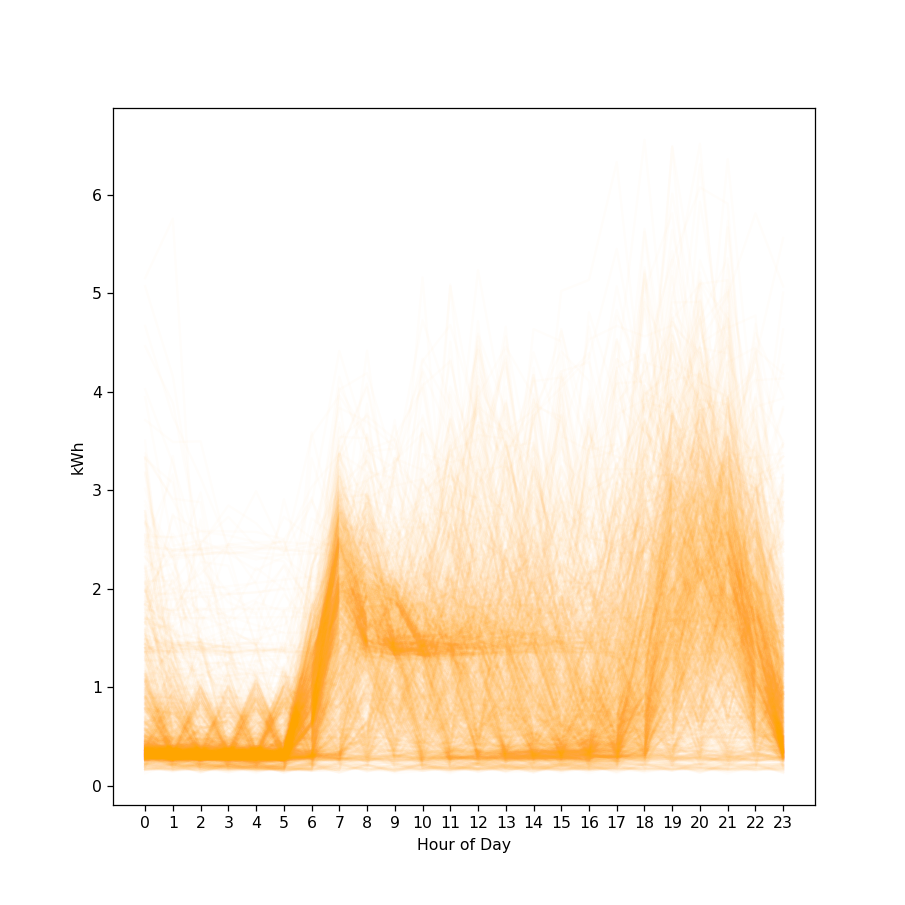

Text(0.5, 0, 'Hour of Day')

In [33]:
ax = pivot_df.T.plot(figsize=(8,8), legend=False, color='orange', alpha=0.02)

list_hour = [i for i in range(24)]


ax.set_ylabel('kWh')
ax.set_xticks(list_hour)

ax.set_xticklabels(list_hour)
ax.set_xlabel('Hour of Day')


By looking at the plot above, we can hardly see different groups of consumption profiles. Although we can notice days where the consumption is pretty high and others where it is low.

We can finally get to the fun part and run our clustering algortihm, in our case KMeans

# Building Model

**Explanation on KMeans and how to evaluate your algorithm**

KMeans is an unsupervised machine learning algorithm that can be tuned with using hyperparameters. Hyperparameters are model configuration properties that define the model and remain constant during the training of the model. For KMeans clustering, here are the 3 different hyperparameters that can be tuned.

* Numbuer of Centeroids - Clusters 
* Seeds - Initial Value
* Distance Measures


In this project, we will focus on the optimization of the number of Clusters also called the value of **K**

To determine the value of K two methods are commonly used, the **Elbow Method** and the **Silhouette Method**. We will be focusing on this latter for this project.


## The Silhouette Method

For a given number of centeroids, the silhouette method will calculate what we call silhouette coefficients for each point in our dataset. Here is the mathematical formula of a silhouette coefficient 
<br>

$S_{i} = \frac{b_{i}-a_{i}}{max(a_{i},b_{i})}$
<br>

**Where**:
* i represents a point of our dataset
<br> 
* a represents the avarage distance between point i and all the other points in the same cluster 
<br>
* b represents the average distance between point i and the other points from the nearest cluster.



From this expression we can notice that a silhouette coefficient ranges between -1 and 1. With 1 being the ideal value and -1 the worst value.
<br>
After having calculated each silhouette coefficient, we can determine the final silhouette score by calculating the mean of of our coefficient. So for a given number k, the silhouette score is calculated with the following equation

$Silhouette Score_{k} = \frac{1}{n}\sum \limits _{i=1}^{n}S_{i}$



We repeat this process for different values of K. We will only retain the values closest to 1 when validating our model. I wrote the closest values **(plural)** and not the closest value **(singular)** because sometimes we do not always want to take the k-value associated with the highest silhouette score according to what we are trying to get from our data.

Here is the pseudocode for the Silhouette Method:
<br>

* Pick a range of values of K
* For each value of K
    * Apply Kmeans on data
    * Calculate silhouette coefficients
    * Calculate silhouette Score
    * Plot Silhouette for value of K
* Choose K that gives good silhouette score


For mor information about silhouette method I invite you to click [HERE](https://www.youtube.com/watch?v=AtxQ0rvdQIA&t=16s)

Now without further ado, let's code our model :)

In [34]:
sil_scores = [] # array for silhouette scores corresponding to each value of K
n_cluster_list = np.arange(2,31).astype(int) 

Values of K will range from **2 to 31** to calculate the silhouette scores

In [35]:
X = pivot_df.values.copy()

standard_scaler = MinMaxScaler()
X_prepared = standard_scaler.fit_transform(X)



In [36]:
# Iterating over our values of K
for num_cluster in n_cluster_list:
    
    kmeans = KMeans(n_clusters=num_cluster, n_init=10)
    cluster_found = kmeans.fit_predict(X_prepared)
    sil_scores.append(silhouette_score(X, kmeans.labels_))    

For those who are interested in understanding the piece of code above we are running KMeans on our data for dfferent values of K (from 2 to 31).

For a given value of K, we are running Kmeans 10 times (**n_init** argument) where each time different seeds (centeroids) are set at the beginning. We will keep the seeds that give the best output before calculating silhouette scores.

In [37]:
sil_scores # Displaying different silhouette scores for different values of K

[0.19549576297691978,
 0.1424668494925337,
 0.14592479965891125,
 0.1418892111339809,
 0.09286743510695873,
 0.09757962423340627,
 0.09208176036328557,
 0.10108952702194499,
 0.09702922752423697,
 0.09667129216681415,
 0.09347891679657103,
 0.09687357155731734,
 0.07845039267912532,
 0.09395399294305629,
 0.09336955235028027,
 0.07635146900925377,
 0.08106498263696664,
 0.07962537250176502,
 0.08082323498065733,
 0.07828812847808082,
 0.0823014616736401,
 0.07910843924886697,
 0.07473304380874864,
 0.07094287276508195,
 0.0727914356813639,
 0.07818539198495353,
 0.06959782199783224,
 0.07885519616622057,
 0.07366923978115635]

Now let's plot the silhouette scores versus the number of centeroids

<IPython.core.display.Javascript object>


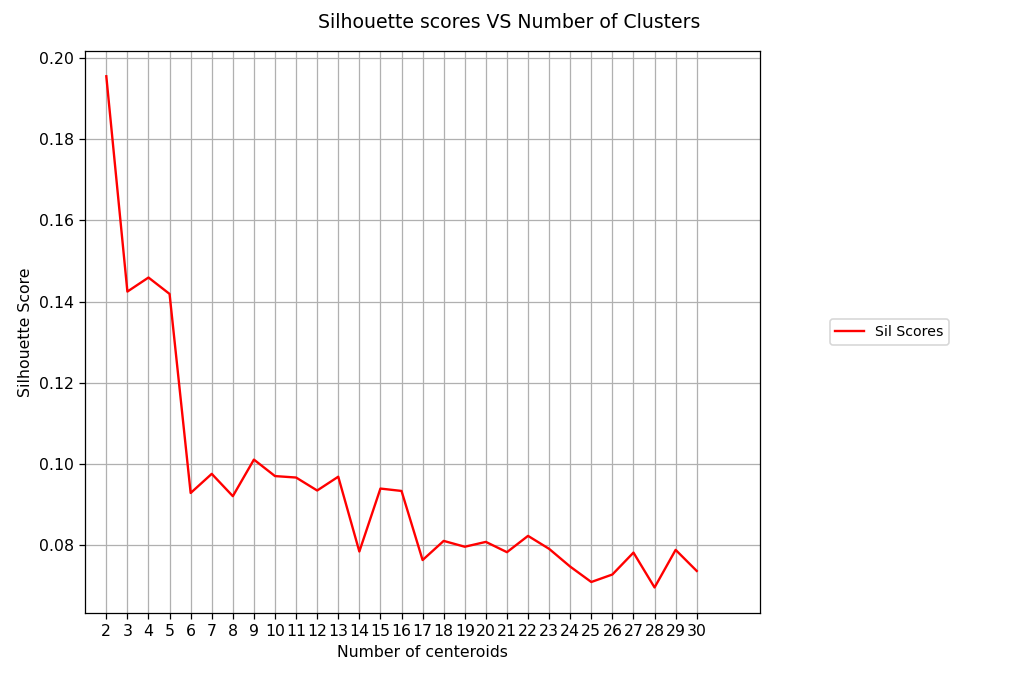

In [38]:
fig, axs = plt.subplots(1, 2, sharex=True, 
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 1]})


pax, _ = axs
pax.plot(n_cluster_list, sil_scores, label="Sil Scores",
         color="red", linewidth=1.5)
pax.grid(True)
#-----------------
pax.set_xlim([1, 33])
pax.set_xticks(n_cluster_list)
# pax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%H"))
# pax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%b %d"))
pax, lax = axs
pax.set_ylabel("Silhouette Score")
pax.set_xlabel("Number of centeroids")
lax.axis('off')
lax.legend(*pax.get_legend_handles_labels(), loc=10, fontsize=9)


# ----------------
fig.suptitle("Silhouette scores VS Number of Clusters")
#fig.suptitle("From {} to {})".format(start, end))
fig.tight_layout(rect=[0, 0, 1, 0.95])
# savefig(fig_name='simulated_plot_site_cons', path=DIR_FIG)



By analysing the plot above, we can see that we have the highest silhouette score for 2 centeroids with a value of 0.195. Nonetheless, the scores for **2**, **3** and **4** centeroids are not bad with respectively **0.142**; **0.146**; and **0.139**. Above that the coefficients are too low


Since the value are not that different from one to another, let's choose **3 centeroids** and see how it performs.

## Clustering usage profiles (3 Centeroids)

In [39]:
kmeans = KMeans(n_clusters=3)

In [40]:
cluster_found = kmeans.fit_predict(X)

In [41]:
cluster_found_sr = pd.Series(cluster_found, name='cluster')

In [42]:
cluster_found_sr

0       2
1       2
2       0
3       2
4       0
       ..
1435    1
1436    2
1437    0
1438    0
1439    0
Name: cluster, Length: 1440, dtype: int32

In [43]:
pivot_df = pivot_df.set_index(cluster_found_sr, append=True)

<IPython.core.display.Javascript object>


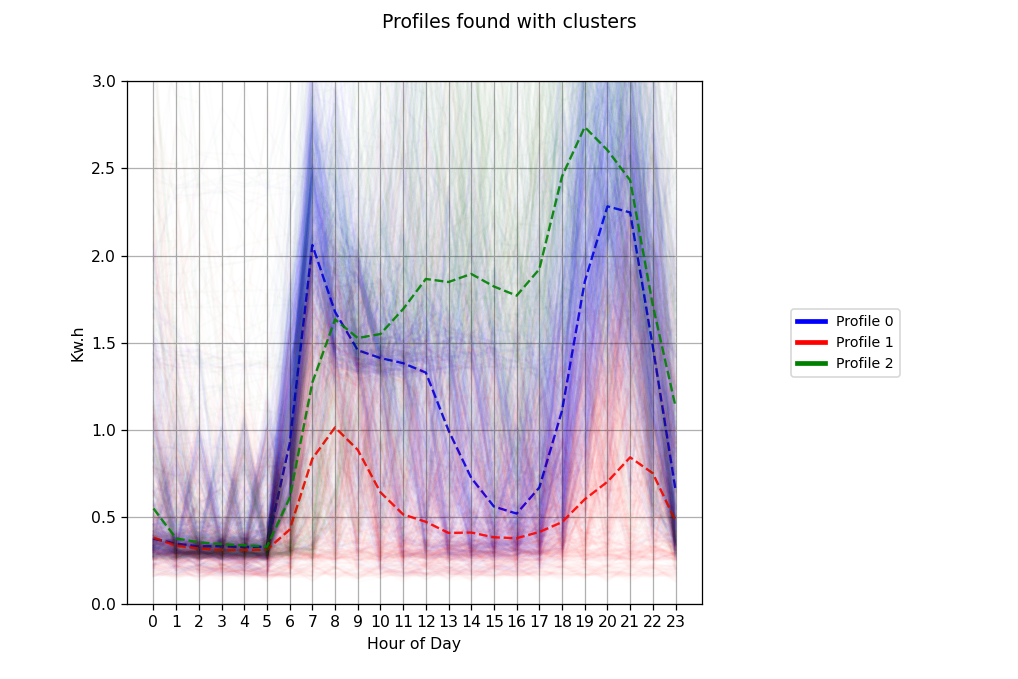

Text(0.5, 0.98, 'Profiles found with clusters')

In [44]:
fig, axs = plt.subplots(1, 2, sharex=True, 
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [4, 1]})


color_list = ['blue', 'red', 'green']

cluster_values = sorted(pivot_df.index.get_level_values('cluster').unique())

pax, lax = axs

for cluster, color in zip(cluster_values, color_list):
    pivot_df.xs(cluster, level=1).T.plot(
        ax=pax, legend=False, alpha=0.01, color=color, label= f'Cluster {cluster}'
        )
    pivot_df.xs(cluster, level=1).median().plot(
        ax=pax, color=color, alpha=0.9, ls='--'
    )
pax.grid(True)
pax.set_xticks(list_hour)
pax.set_xticklabels(list_hour)
pax.set_xlabel('Hour of Day')
pax.set_ylabel('Kw.h')
pax.set_ylim(bottom=0, top=3)


# legend

lax.axis('off')
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in color_list]
labels = ['Profile 0', 'Profile 1', 'Profile 2']
lax.legend(lines, labels, loc=10, fontsize=9)


fig.suptitle("Profiles found with clusters")


Above, we have plotted and colored each profile to its corresponding cluster. Also, for each cluster, we have plotted in dashed lines the consumption mean corresponding to each cluster. We can clearly identify three different energy fingerprints.<br>
* The **Green** cluster shows peak in consumption during the morning then a decline throuhout the entire afternoon and finally another peak at night. This looks like a **typical business day** when occupants leave for work or school.
<br>
* In the **Red** cluster we have a steady consumption throughout the entire day which could be a weekend or a special day when everyone is at home.
<br>
* Concerning the **Blue** cluster we have what could represent a holiday where the occupants are not at home the entire  day and only a few applicances are left on. 

# Validating Results with t-SNE

In order to validate our model we will use t-SNE that is method of dimensionality reduction that takes a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane.<br>In our case we are shifting to  24 dimensions space to a 2 dimensions space.

Theoretically this methods gives us a representation of the distance between points if we were able to observe them in 24D.

In [45]:
tsne = TSNE()
results_tsne = tsne.fit_transform(X)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(cluster_values, color_list)

<IPython.core.display.Javascript object>


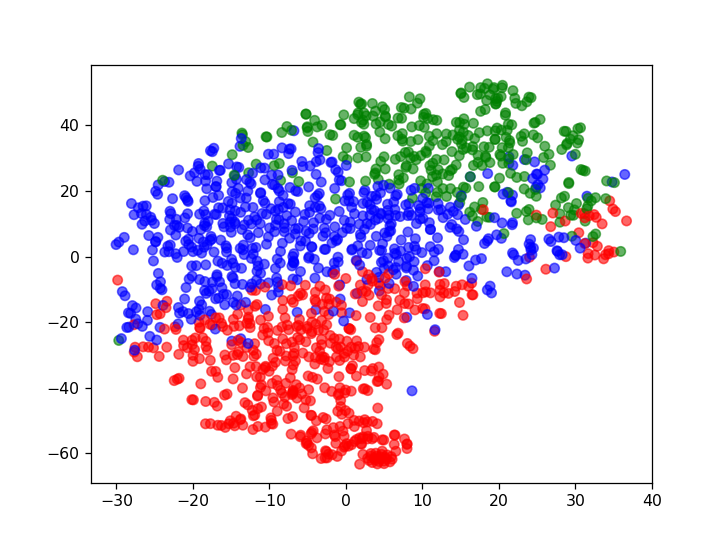

In [46]:
plt.figure()
plt.scatter(results_tsne[:,0], results_tsne[:,1],
    c=pivot_df.index.get_level_values('cluster'),
    cmap=cmap, 
    alpha=0.6, 
    )

In the above plot, each point represents a daily load-profile. They were reduced from 24 to 2 dimensions. Theoretically, the distance between points in the higher dimensional space was preserved, so points that are close together refer to similar load-profiles. The fact that Red, Blue and Green points are pretty much close together shows us that our clustering worked well.

# Conclusion

Throughout this project I tried to present the different steps when identifying usage profiles using KMeans. We were able to present the processing when acquiring data, the pre-analysis and the building as well as validation of the model. 

Many other things could be done in this project such as:


* Compare the results of our clustering with a real calendar and check if points classified in the different clusters correspond to a business day, weekend or holiday.
* Try other clustering algorithms that could work just as fine as this one. 
* Acquiring more data of different households and identify consumption profiles between households, of a neigbourhood, city or country.
* And many other things....

Voila! this is the end of the notebook, hope you enjoyed it and feel free to contact me if you have any questions or if you are interested on working on a project.
<br><br><br>



_"Keep moving, Keep growing, Keep learning and see you at work"_ <br>
**D.W.**

**END OF NOTEBOOK**

**Contact**:<br>
* [Linkedin](https://www.linkedin.com/in/seydou-dia-325b04139)
* @:seydou.dia@insa-lyon.fr<br>
<br>

**References used to conduct the project** :
* Aurélien Géron, (2017). _Hands-On Machine Learning with Scikit-Learn and TensorFlow_. O'reilly
* Wes McKinney, (2017). _Python for Data Analysis_. O'reilly
* Luciano Guivant Viola, (2018). _Clustering electricity profiles with k-means_. TowardsDataScience
* Lucas Parisi, (2019). _0405 Number of Clusters as a Hyperparameter The Elbow and Silhouette Method_. Youtube video
